In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

## Load data

The dataset is the adult dataset which can be downloaded from the UCI machine learning repository.

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [2]:
import pandas as pd
from urllib.request import urlopen
from sklearn.preprocessing import LabelEncoder

name_data = urlopen('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names')
lines = [l.decode("utf-8") for l in name_data if ':' in l.decode("utf-8") and '|' not in l.decode("utf-8")]

features = [l.split(':')[0] for l in lines]
label_name = 'income'

cat_features = [l.split(':')[0] for l in lines if 'continuous' not in l]

train_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                       names=features + [label_name])
test_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',
                      names=features + [label_name], skiprows=1)

test_df[label_name] = test_df [label_name].str[:-1]

encoder = LabelEncoder()
encoder.fit(train_df[label_name])
train_df[label_name] = encoder.transform(train_df[label_name])
test_df[label_name] = encoder.transform(test_df[label_name])

## Process into dataset

In [3]:
from deepchecks import Dataset

cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 
                'race', 'sex', 'native-country']
train_ds = Dataset(train_df, label_name=label_name, cat_features=cat_features)
test_ds = Dataset(test_df, label_name=label_name, cat_features=cat_features)

numeric_features = list(set(train_ds.features) - set(cat_features))

In [4]:
train_ds.label_name

'income'

## Whole Dataset Drift

In [5]:
from deepchecks.checks import WholeDatasetDrift

Whole Dataset Drift

Calculate drift between the entire train and test datasets using a model trained to distinguish between them.

Conditions Summary

Status,Check,Condition,More Info
✓,Whole Dataset Drift,Drift value is not greater than 0.25,


Additional Outputs

The shown features are the features that are most important for the domain classifier - the
 domain_classifier trained to distinguish between the train and test datasets. The percents of
 explained dataset difference are the calculated feature importance values for the feature.

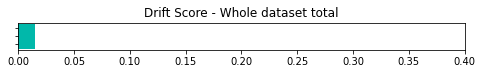

Main features contributing to drift

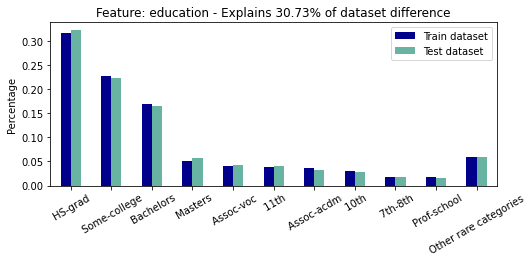

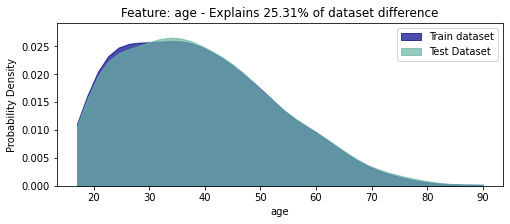

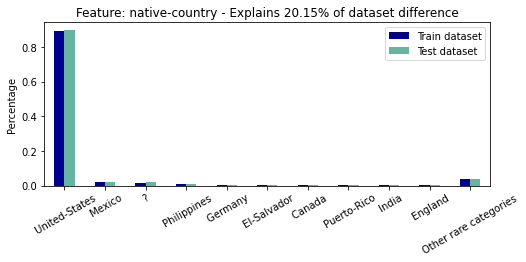

In [11]:
check = WholeDatasetDrift().add_condition_overall_drift_value_not_greater_than()
check.run(train_dataset=train_ds, test_dataset=test_ds)

## Introduce drift to dataset

In [7]:
sample_size = 10000
random_seed = 0

In [8]:
train_drifted_df = pd.concat([train_ds.data.sample(min(sample_size, train_ds.n_samples) - 5000, random_state=random_seed), 
                             train_ds.data[train_ds.features_columns['sex'] == ' Female'].sample(5000, random_state=random_seed)])
test_drifted_df = test_ds.data.sample(min(sample_size, test_ds.n_samples), random_state=random_seed)

train_drifted_ds = Dataset(train_drifted_df, label_name=label_name, cat_features=cat_features)
test_drifted_ds = Dataset(test_drifted_df, label_name=label_name, cat_features=cat_features)

Whole Dataset Drift

Calculate drift between the entire train and test datasets using a model trained to distinguish between them.

Conditions Summary

Status,Check,Condition,More Info
✖,Whole Dataset Drift,Drift value is not greater than 0.25,"Found drift value of: 0.32, corresponding to a domain classifier AUC of: 0.66"


Additional Outputs

The shown features are the features that are most important for the domain classifier - the
 domain_classifier trained to distinguish between the train and test datasets. The percents of
 explained dataset difference are the calculated feature importance values for the feature.

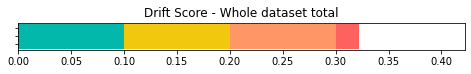

Main features contributing to drift

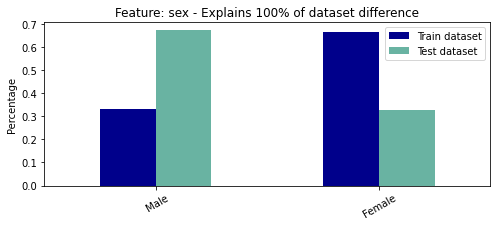

In [12]:
check = WholeDatasetDrift().add_condition_overall_drift_value_not_greater_than()
check.run(train_dataset=train_drifted_ds, test_dataset=test_drifted_ds)